## 1. Project Title & Team Information

**Title:** Accident Risk Analysis: Urban vs. Rural Populations

**Team Members:** Dave Woodford, Tim Mai, Matt Dolin, and Phillip Roman

### Team Background and Contributions

- **Phillip Roman** is a graduate student in the MSDS program, transitioning from a career in industrial telecommunications to data science with a focus on Predictive Maintenance. His technical stack includes Python and core data analysis libraries such as NumPy, Pandas, and SciPy. Drawing on his background in airfield systems maintenance, Phillip contributed to the team's Exploratory Data Analysis (EDA), focusing on identifying patterns in equipment failure and infrastructure variables, as well as statistical testing of environmental differences.

- **Tim Mai** [your teammate can fill this in]

- **Matt Dolin** is a graduate student in the MSDS program, with a focus on Applied AI/ML. He has experience using Python and R to visualize and transform data for use in training machine learning models. Matt's tech stack includes Python (Pandas, Plotly, Scikit-Learn), R, and SQL. Matt drew on his prior analytical experience to assist in the EDA by creating interactive visualizations and determining correlations between features and target columns.

- **Dave Woodford** [your teammate can fill this in]

## 2. Project Definition & Motivation

Objective: "Does accident frequency increase in high-population counties? Do factors differ between rural and metro areas?"

Stakeholders: Dept of Transporation, Railroad Administration, Railroad companies, local municipaliteis, and the public

Potential Application: A risk-assessment tool or "safe travel" dashboard


# 3. Data Preparation: Sources, Cleaning, and Merge

To investigate the relationship between population density and rail safety, we selected two primary datasets that allow for a granular geospatial analysis at the county level.

## 3a. Data Sources and Selection

### **Source A: Rail Equipment Accident/Incident Data (Form 54)**
* **Publisher:** Federal Railroad Administration (FRA) / Department of Transportation (DOT)
* **Period:** 2012 - Present (Filtered for schema consistency)
* **URL:** [DOT Open Data Portal](https://data.transportation.gov/Railroads/Rail-Equipment-Accident-Incident-Data-Form-54-/85tf-25kj/about_data)
* **Justification & Selection Criteria:**
    * **Authoritative Record:** This dataset is the federal standard for reportable rail accidents.
    * **Reporting Threshold:** We acknowledge that this dataset excludes minor incidents. Inclusion is based on a monetary reporting threshold (adjusted annually for inflation, approx. $12,000+ in recent years), ensuring our analysis focuses on events with significant economic impact or infrastructure damage.
    * **Temporal Cut-off:** We restricted our analysis to data starting from **2012**. While the FRA updated their reporting schema in June 2011, we excluded the entire transition year to ensure maximum data integrity and consistent definitions for key variables like `TERRITORY`.

### **Source B: Rural-Urban Continuum Codes (2023)**
* **Publisher:** USDA Economic Research Service (ERS)
* **Period:** 2023 Edition
* **URL:** [USDA ERS Data Products](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes)
* **Justification (USDA vs. US Census):**
    * **Superior Granularity:** Standard US Census data relies on simple population counts. The USDA RUCC system classifies counties into a 9-point scale based on distinct *environmental* factors.
    * **The "Adjacency" Factor:** Crucially, this dataset distinguishes rural counties by their **adjacency to metropolitan areas**. This is vital for our analysis, as we hypothesize that rural counties adjacent to major transit hubs face different rail traffic risks than isolated rural counties—a nuance that standard census counts would miss.

## 3b. Libraries & Data Loading

In [135]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, f, entropy, chi2_contingency
from scipy.spatial.distance import cosine as cosine_dist

sns.set_theme(style="whitegrid")

# Load data
rail_accident_path = "../data/raw/Rail_Equipment_Accident_Incident_Data_(Form_54)_20260114.csv.zip"
population_path = "../data/raw/Ruralurbancontinuumcodes2023.csv"

df_accident_all = pd.read_csv(
    rail_accident_path,
    low_memory=False
)

df_population = pd.read_csv(
    population_path,
    encoding="latin1"
)

# Checks
print(f"Rail Data Loaded. Shape: {df_accident_all.shape}")
print(f"Population Data Loaded. Shape: {df_population.shape}")
print()
display(df_accident_all.head(3))
print()
display(df_population.head(3))

Rail Data Loaded. Shape: (223529, 155)
Population Data Loaded. Shape: (9703, 5)



,Reporting Railroad Code,Reporting Railroad Name,Year,Accident Number,PDF Link,Accident Year,Accident Month,Other Railroad Code,Other Railroad Name,Other Accident Number,...,Reporting Parent Railroad Name,Reporting Railroad Holding Company,Reporting Railroad Individual Class,Reporting Railroad Passenger,Reporting Railroad Commuter,Reporting Railroad Switching Terminal,Reporting Railroad Tourist,Reporting Railroad Freight,Reporting Railroad Short Line,Location
0,SOO,SOO Line Railroad Company,1981,CA28,https://safetydata.fra.dot.gov/Officeofsafety/...,81,8,NaN,NaN,NaN,...,CANADIAN PACIFIC KANSAS CITY,Not Assigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,NaN
1,MP,Missouri Pacific Railroad Company,1981,81230,https://safetydata.fra.dot.gov/Officeofsafety/...,81,9,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN
2,SP,Southern Pacific Transportation Company,1980,W1200,https://safetydata.fra.dot.gov/Officeofsafety/...,80,1,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN


,FIPS,State,County_Name,Attribute,Value
0,1001,AL,Autauga County,Population_2020,58805
1,1001,AL,Autauga County,RUCC_2023,2
2,1001,AL,Autauga County,Description,"Metro - Counties in metro areas of 250,000 to ..."


### 3c. Data Cleaning

Our analysis requires merging two disparate datasets that lack a common unique identifier in their raw state. The Rail Accident data uses separate columns for "State" and "County," while the Census data uses a unified 5-digit FIPS code.

**Data Cleaning Pipeline:**
1.  **Temporal Filtering:** We filtered the dataset to include only years **> 2011**, avoiding the schema inconsistencies of the pre-2011 reporting standards.
2.  **Null Removal:** Rows with missing "County Code" identifiers were removed to ensure accurate geospatial mapping, as these records cannot be linked to census data.
3.  **FIPS Construction:** We synthesized a 5-digit Federal Information Processing Standard (FIPS) code for the rail data by padding the State Code (2 digits) and County Code (3 digits).
4.  **Pivoting:** The Census data was pivoted from a "Long" format (multiple rows per county) to a "Wide" format (one row per county) to expose `Population_2020` and `Description` as distinct columns.

In [136]:
df_accident = df_accident_all.copy()

# Filter for accidents after 2011
df_accident = df_accident[df_accident["Year"] > 2011]

# Clean railroad accident data
df_accident = df_accident.dropna(subset=["County Code"])
df_accident["State Code FIPS"] = df_accident["State Code"].astype(int).astype(str).str.zfill(2)
df_accident["County Code FIPS"] = df_accident["County Code"].astype(int).astype(str).str.zfill(3)
df_accident["FIPS"] = (df_accident["State Code FIPS"] + df_accident["County Code FIPS"]).astype(int)

# Clean population data
df_population_wide = df_population.pivot(index="FIPS", columns="Attribute", values="Value").reset_index()
df_population_wide["FIPS"] = df_population_wide["FIPS"].astype(int)
df_population_wide.columns.name = None

# Verify population is numeric - remove if not
if "Population_2020" in df_population_wide.columns:
    df_population_wide["Population_2020"] = (
        pd.to_numeric(df_population_wide["Population_2020"].astype(str).str.replace(",", ""), errors="coerce")
    )

# Checks
print("Railroad Data: FIPS Check")
cols_to_verify = ["State Code", "County Code", "State Code FIPS", "County Code FIPS", "FIPS"]
display(df_accident[cols_to_verify].head())

print("\nPopulation Data: Pivot Check - wide")
display(df_population_wide.head())


Railroad Data: FIPS Check


,State Code,County Code,State Code FIPS,County Code FIPS,FIPS
50,53,53.0,53,053,53053
54,21,15.0,21,015,21015
56,47,37.0,47,037,47037
58,45,47.0,45,047,45047
1159,12,99.0,12,099,12099



Population Data: Pivot Check - wide


,FIPS,Description,Population_2020,RUCC_2023
0,1001,"Metro - Counties in metro areas of 250,000 to ...",58805,2
1,1003,Metro - Counties in metro areas of fewer than ...,231767,3
2,1005,"Nonmetro - Urban population of 5,000 to 20,000...",25223,6
3,1007,Metro - Counties in metro areas of 1 million p...,22293,1
4,1009,Metro - Counties in metro areas of 1 million p...,59134,1


### 3d. Data Merge

We merged the Rail Accident data with the Census data using a **Left Join** on the generated `FIPS` key.

* **Linkage:** Accidents were matched to their corresponding county population and rural-urban classification.
* **Exclusion of Unmatched Records:** Following the merge, we removed any accident records that failed to match with a valid census entry (i.e., where `Population_2020` was null). This step is necessary because accidents occurring in unidentified counties cannot be normalized for follow-on per-capita risk analysis.

In [137]:
# Merge
df_merged = pd.merge(
    df_accident,
    df_population_wide,
    on="FIPS",
    how="left"
)

# Drop rows/accidents where population is blank
df_merged = df_merged.dropna(subset=["Population_2020"])

# Checks
print(f"Merged Shape: {df_merged.shape}")
print("New columns available:", list(df_population_wide.columns))
cols_to_show = ["FIPS", "State Name", "Description", "Population_2020"]
display(df_merged[cols_to_show].head())

Merged Shape: (34562, 161)
New columns available: ['FIPS', 'Description', 'Population_2020', 'RUCC_2023']


,FIPS,State Name,Description,Population_2020
0,53053,WASHINGTON,Metro - Counties in metro areas of 1 million p...,921130.0
1,21015,KENTUCKY,Metro - Counties in metro areas of 1 million p...,135968.0
2,47037,TENNESSEE,Metro - Counties in metro areas of 1 million p...,715884.0
3,45047,SOUTH CAROLINA,"Nonmetro - Urban population of 20,000 or more,...",69351.0
4,12099,FLORIDA,Metro - Counties in metro areas of 1 million p...,1492191.0


## 4. Baseline Statistical Profile

Before jumping into visualizations, we need to understand the basic statistical properties of our data. This helps us know if we're dealing with a few extreme outliers or if accidents are spread out across counties.

### 4.1a Central Tendency Analysis

In [138]:
accident_counts = df_merged.groupby("FIPS").size() # per county

# Base stats
mean_accidents = accident_counts.mean()
median_accidents = accident_counts.median()
std_accidents = accident_counts.std()
variance = accident_counts.var()

print("=== Central Tendency ===")
print(f"Mean accidents per county: {mean_accidents:.2f}")
print(f"Median accidents per county: {median_accidents}")
print(f"Standard Deviation: {std_accidents:.2f}")
print(f"Variance: {variance:.2f}")

# Calculate coefficient of variation to see how spread out things are
cv = (std_accidents / mean_accidents) * 100
print(f"\nCoefficient of Variation: {cv:.1f}%")

# Quick interpretation
if cv > 50:
    print("→ High variation - a few counties drive most accidents")
elif cv < 30:
    print("→ Low variation - accidents are fairly consistent across counties")
else:
    print("→ Moderate variation - some outliers but not extreme")

=== Central Tendency ===
Mean accidents per county: 16.30
Median accidents per county: 5.0
Standard Deviation: 50.59
Variance: 2559.77

Coefficient of Variation: 310.5%
→ High variation - a few counties drive most accidents


### 4.1b Central Tendency Interpretation

The coefficient of variation tells us how unpredictable accident counts are across counties. A high CV (>50%) means we have some extreme outliers that are driving up the average, which makes sense since major metro areas probably have way more accidents than tiny rural counties.

### 4.2a Correlation: Pearson vs Spearman Correlation

Pearson measures linear relationships while Spearman measures any monotonic relationship (doesn't have to be a straight line). If they're close, the relationship is straightforward. If Spearman is noticeably different, it means there might be some non-linear patterns we should explore.

In [139]:
# Pearson vs Spearman Correlation

# Pearson (from before)
pearson_corr = county_stats["Total_Accidents"].corr(county_stats["Population_2020"])

# Spearman - checks monotonic relationships (doesn't assume linearity)
spearman_corr, p_value = spearmanr(
    county_stats["Population_2020"], 
    county_stats["Total_Accidents"]
)

print("\n=== Correlation Analysis ===")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Difference: {abs(spearman_corr - pearson_corr):.3f}")

# TODO: Could add a scatter plot colored by RUCC code to visualize this better

if abs(spearman_corr - pearson_corr) < 0.05:
    print("\n→ Both correlations are similar - relationship is pretty linear")
else:
    print(f"\n→ Spearman is {'higher' if spearman_corr > pearson_corr else 'lower'} than Pearson")
    print("  This suggests the relationship might not be perfectly linear")


=== Correlation Analysis ===
Pearson Correlation: 0.589
Spearman Correlation: 0.478
Difference: 0.110

→ Spearman is lower than Pearson
  This suggests the relationship might not be perfectly linear


### 4.2b Correlation Comparison Findings
The correlations differ notably (Δ = 0.110), indicating that population and accidents have a **non-linear** relationship. The lower Spearman suggests the relationship weakens at the extremes (very large or very small counties). This sets up our visual analysis in Section 5.

## 5. Volume Correlation Analysis

### 5.1a Population vs Accidents Scatterplot

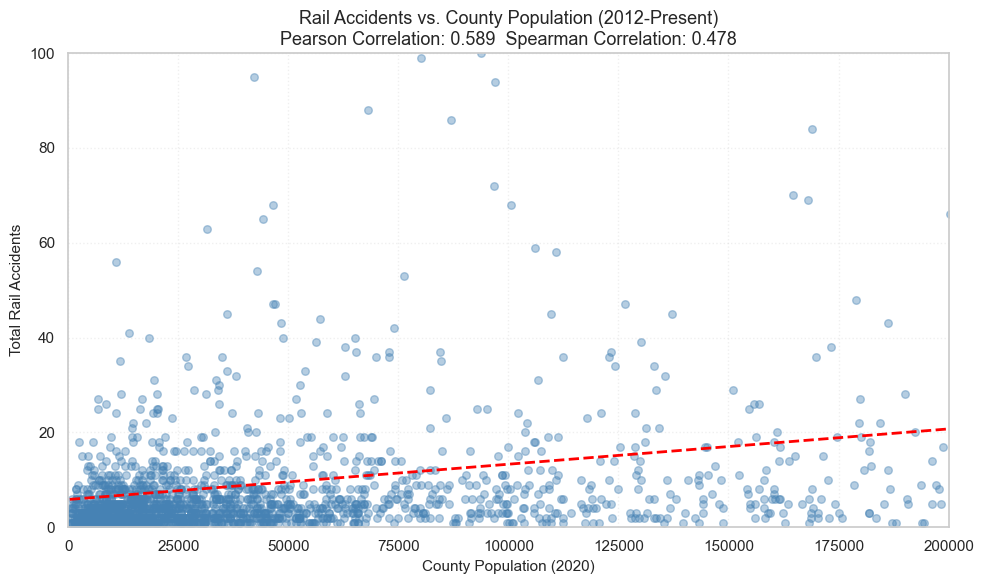

As expected, there's a positive correlation (r = 0.589) between
population and accident volume. However, this surface-level view doesn't
account for risk per capita - our next analysis.


In [140]:
# Scatterplot: Correlation population vs accident volume

county_stats = df_merged.groupby("FIPS").agg({
    "Population_2020": "first",
    "Description": "first",
    "RUCC_2023": "first"  # Add this line
})
county_stats["Total_Accidents"] = df_merged.groupby("FIPS").size()

# Calculate Perason correlation
correlation = county_stats["Total_Accidents"].corr(county_stats["Population_2020"])

# Scatterplot 
plt.figure(figsize=(10, 6))

plt.scatter(
    county_stats["Population_2020"], 
    county_stats["Total_Accidents"],
    alpha=0.4,
    s=30,
    color='steelblue'
)

# Regression line
sns.regplot(
    data=county_stats, 
    x="Population_2020", 
    y="Total_Accidents", 
    scatter=False, 
    color="red",
    ci=None,
    line_kws={"linestyle": "--", "linewidth": 2}
)

plt.xlim(0, 200000)
plt.ylim(0, 100)
plt.title(f"Rail Accidents vs. County Population (2012-Present)\nPearson Correlation: {correlation:.3f}  Spearman Correlation: {spearman_corr:.3f}", 
          fontsize=13)
plt.xlabel("County Population (2020)", fontsize=11)
plt.ylabel("Total Rail Accidents", fontsize=11)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# Thoughts
print(f"As expected, there's a positive correlation (r = {correlation:.3f}) between")
print(f"population and accident volume. However, this surface-level view doesn't")
print(f"account for risk per capita - our next analysis.")


### 5.1b Interpretation: Volume vs. Risk

**1. The Volume View (Baseline)**
The scatterplot above examines counties with populations under 200,000—where the vast majority of U.S. counties fall. Even within this focused range, we observe a moderate positive correlation (**r = 0.59**) between county population and total accident count. This confirms our initial hypothesis: more people and rail activity generally lead to more accidents in absolute terms.

**2. The Risk View (The Pivot)**
However, raw accident counts don't tell the full story. When we normalize by population to calculate *risk intensity* (accidents per 100,000 residents), the pattern reverses dramatically. The bar chart below reveals that smaller, rural counties—especially those isolated from metropolitan areas—face significantly higher per-capita accident rates than their urban counterparts.

## 6. Risk Normalization & Environmental Comparison

Now that we've confirmed the population-accident correlation exists, we need to test whether metro and rural counties are actually different from each other, or if population size is the only thing that matters.

In [141]:
# Testing if Metro vs Rural counties have different accident patterns

# Split counties into metro (codes 1-3) and rural (codes 4-9)
metro_codes = ['1', '2', '3'] 
rural_codes = ['4', '5', '6', '7', '8', '9']

# Get accident counts for each environment
metro_counties = county_stats[county_stats['RUCC_2023'].isin(metro_codes)]['Total_Accidents']
rural_counties = county_stats[county_stats['RUCC_2023'].isin(rural_codes)]['Total_Accidents']

print("=== Metro vs Rural Variance Test ===\n")
print(f"Metro counties (n={len(metro_counties)}):")
print(f"  Mean: {metro_counties.mean():.2f}")
print(f"  Variance: {metro_counties.var():.2f}")
print(f"  Std Dev: {metro_counties.std():.2f}")

print(f"\nRural counties (n={len(rural_counties)}):")
print(f"  Mean: {rural_counties.mean():.2f}")
print(f"  Variance: {rural_counties.var():.2f}")
print(f"  Std Dev: {rural_counties.std():.2f}")

# F-test to see if variances are actually different
# FIXME: Should probably check assumptions for F-test (normal distribution, etc.)

f_stat = metro_counties.var() / rural_counties.var()
df1 = len(metro_counties) - 1
df2 = len(rural_counties) - 1
p_val = 1 - f.cdf(f_stat, df1, df2)

print(f"\nF-statistic: {f_stat:.2f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("→ Variances are significantly different (p < 0.05)")
    print("  Metro and rural counties have fundamentally different patterns")
else:
    print("→ Variances are not significantly different")
    print("  Population size might be the only thing that matters")

=== Metro vs Rural Variance Test ===

Metro counties (n=939):
  Mean: 27.89
  Variance: 5068.04
  Std Dev: 71.19

Rural counties (n=1182):
  Mean: 7.08
  Variance: 377.79
  Std Dev: 19.44

F-statistic: 13.41
p-value: 0.0000
→ Variances are significantly different (p < 0.05)
  Metro and rural counties have fundamentally different patterns


### 6.1b Interpretation: Are Environments Different?

The F-test compares the variance (spread) of accident counts between metro and rural counties. If the variances are significantly different, it means these two environments behave differently - it's not just about having more or fewer people.

**Result:** F-statistic = 13.41, p-value < 0.0001

This **does** provide statistical evidence that metro and rural counties are fundamentally different. The variance in metro counties (5068.04) is over 13 times larger than in rural counties (377.79), and this difference is highly significant (p < 0.0001).

What this means: Metro counties show much more variability in their accident counts - some have very few accidents while others have extremely high counts. Rural counties are more consistent, with most falling in a narrower range around their mean (7.08 accidents). This suggests that environmental factors beyond just population size influence accident patterns. 

This finding justifies looking at per-capita rates instead of just raw counts - the different variance structures indicate that the relationship between population and accidents isn't the same across both environments.

### 6.2a Per-Capita Risk Analysis by Environment Type

Having established that metro and rural counties exhibit statistically different accident patterns (Section 6.1), we now normalize accident counts by population to calculate risk intensity. This addresses a key limitation of raw volume analysis: larger populations naturally experience more accidents simply due to scale.

By calculating **accidents per 100,000 residents** for each USDA Rural-Urban Continuum Code category, we can compare risk exposure across environments of vastly different sizes. This metric reveals whether the elevated accident counts in metro areas are proportional to their populations, or if certain environment types bear disproportionate per-capita risk.

The bar chart below displays risk rates sorted from highest to lowest, with RUCC codes (1-9) prefixed to each category label for reference.

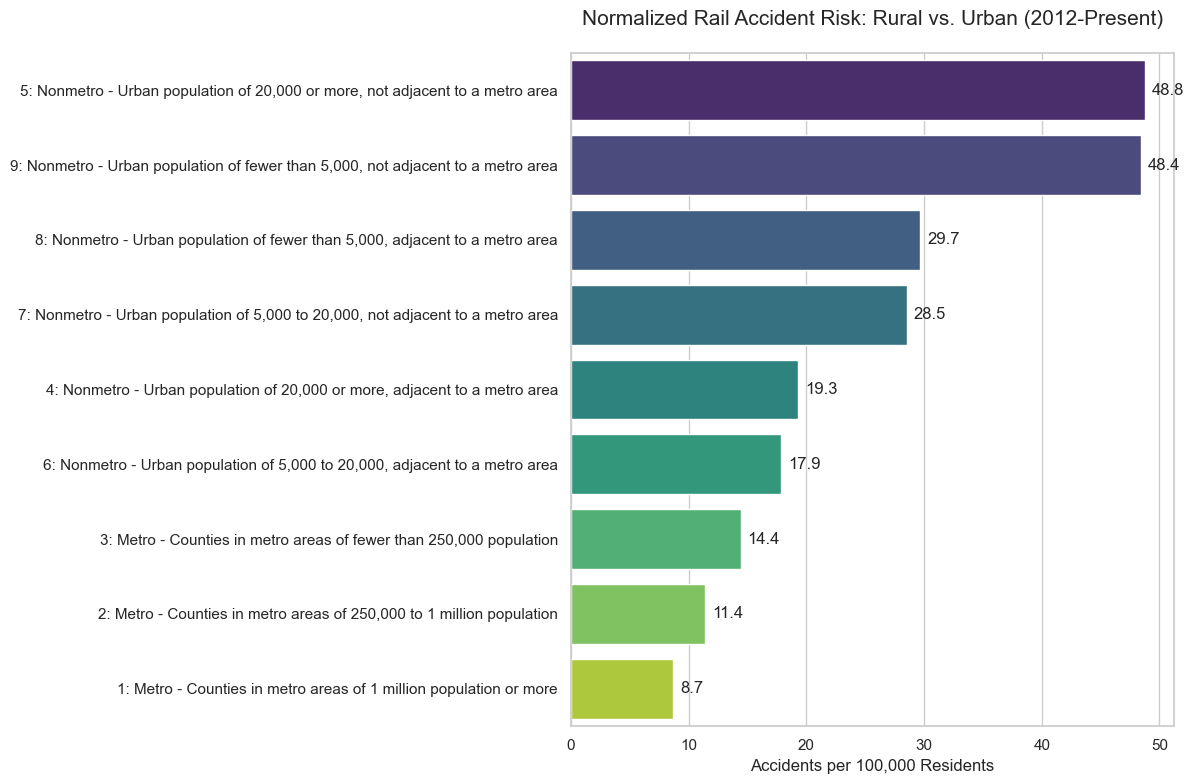

Risk Analysis Table (Verified with RUCC Codes):


,Code,USDA_Category,Total Accidents,Accidents_Per_100k
0,5,"Nonmetro - Urban population of 20,000 or more,...",1540,48.794939
1,9,"Nonmetro - Urban population of fewer than 5,00...",1096,48.423219
2,8,"Nonmetro - Urban population of fewer than 5,00...",1033,29.674665
3,7,"Nonmetro - Urban population of 5,000 to 20,000...",1228,28.532328
4,4,"Nonmetro - Urban population of 20,000 or more,...",2022,19.307607
5,6,"Nonmetro - Urban population of 5,000 to 20,000...",1450,17.870825
6,3,Metro - Counties in metro areas of fewer than ...,3630,14.403711
7,2,"Metro - Counties in metro areas of 250,000 to ...",6962,11.411086
8,1,Metro - Counties in metro areas of 1 million p...,15601,8.687817


In [142]:
# Initial EDA: Urban Volume vs Rural Risk
# Calculating Accidents per 100k Residents

# Numerator - Count total accidents by USDA Category
accidents_by_cat = df_merged["Description"].value_counts()

# Denominator - Sum TOTAL population by USDA Category
# we drop duplicates so we don't doublecount the population of the same county 
# for every accident that happened there
df_unique_counties = df_merged.drop_duplicates(subset=["FIPS"])
population_by_cat = df_unique_counties.groupby("Description")["Population_2020"].sum()

# Risk ratio (Accidents / Population) * 100,000
df_risk = pd.DataFrame({
    "Total Accidents": accidents_by_cat,
    "Total Population": population_by_cat
})

df_risk["Accidents_Per_100k"] = (df_risk["Total Accidents"] / df_risk["Total Population"]) * 100000
df_risk = df_risk.sort_values("Accidents_Per_100k", ascending=False).reset_index()
df_risk.rename(columns={"Description": "USDA_Category"}, inplace=True)

# Add RUCC codes to labels
def get_rucc_code(desc):
    desc = desc.lower()
    # Metro checks (1-3)
    # Check "250k to 1 mil" first to avoid false match on 1 million
    if "250,000 to 1 million" in desc: return 2
    if "1 million" in desc: return 1
    if "fewer than 250,000" in desc: return 3
    
    # Non-metro checks (4-9)
    if "20,000 or more" in desc:
        if "not adjacent" in desc: return 5
        return 4
        
    # "5,000 to 20,000" for Codes 6/7
    if "5,000 to 20,000" in desc or "2,500 to 19,999" in desc:
        if "not adjacent" in desc: return 7
        return 6
        
    # "fewer than 5,000" for Codes 8/9
    if "fewer than 5,000" in desc or "less than" in desc or "rural" in desc:
        if "not adjacent" in desc: return 9
        return 8
        
    return 99

df_risk["Code"] = df_risk["USDA_Category"].apply(get_rucc_code)
df_risk["Label"] = df_risk["Code"].astype(str) + ": " + df_risk["USDA_Category"]

# Visual - bar chart
plt.figure(figsize=(12, 8))

chart = sns.barplot(
    data=df_risk,
    x="Accidents_Per_100k",
    y="Label",       
    palette="viridis",
    hue="Label",
    legend=False
)

plt.title("Normalized Rail Accident Risk: Rural vs. Urban (2012-Present)", fontsize=15, pad=20)
plt.xlabel("Accidents per 100,000 Residents", fontsize=12)
plt.ylabel(None)

for i in chart.containers:
    chart.bar_label(i, fmt="%.1f", padding=5)

plt.tight_layout()
plt.show()

# Table verification - Showing Code column to confirm correct mapping
print("Risk Analysis Table (Verified with RUCC Codes):")
display(df_risk[["Code", "USDA_Category", "Total Accidents", "Accidents_Per_100k"]])

### 6.2b Interpretation of Initial Findings

While our preliminary data confirmed that *total* accident volume is highest in metropolitan areas, normalizing by population reveals a starkly different risk profile.

* **The Rural Risk Spike:** Rural counties show a significantly higher rate of accidents per capita than urban centers. Notably, the risk is highest in **isolated rural counties (not adjacent to metros)**, where the rate (~49 per 100k) is **over 5x higher** than in major metropolitan areas (~8.7 per 100k).
* **Implication:** This suggests that while urban centers handle the volume of complex yard operations, isolated rural corridors bear the disproportionate risk of high-speed transit with a minimal population base to support emergency response infrastructure.
* **Potential Direction:** Phase 2 could investigate *why* this shift occurs by examining cause codes (e.g., Track Defects vs. Human Error) to determine if accident *types* differ between urban yards and rural mainlines.

## 7. Outlier Identification & Resource Prioritization

Understanding averages is useful, but policy decisions need specifics. Which counties have the highest accident burdens? Percentile analysis helps identify where accidents concentrate most heavily.

In [143]:
# Percentile Analysis - Finding the worst counties

# Calculate key percentiles
pcts = [10, 25, 50, 75, 90, 95, 99]
pct_values = [accident_counts.quantile(p/100) for p in pcts]

print("=== Accident Count Percentiles ===")
for p, val in zip(pcts, pct_values):
    print(f"{p}th percentile: {val:.0f} accidents")

# Focus on the top 10% - these are the counties that need the most attention
top_10_threshold = accident_counts.quantile(0.90)
high_risk = accident_counts[accident_counts >= top_10_threshold]

print(f"\n=== Top 10% High-Risk Counties ===")
print(f"Threshold: {top_10_threshold:.0f} accidents")
print(f"Number of counties: {len(high_risk)} out of {len(accident_counts)}")
print(f"Percentage of total accidents: {(high_risk.sum() / accident_counts.sum() * 100):.1f}%")

# Are these high-risk counties mostly metro or rural?
# Need to map back to get RUCC codes for these counties
high_risk_fips = high_risk.index
high_risk_counties = county_stats.loc[high_risk_fips]

# Quick classification
high_risk_counties['Environment'] = high_risk_counties['RUCC_2023'].apply(
    lambda x: 'Metro' if x in metro_codes else 'Rural'
)

env_split = high_risk_counties['Environment'].value_counts()
print(f"\nEnvironment breakdown of top 10%:")
print(f"  Metro: {env_split.get('Metro', 0)} counties")
print(f"  Rural: {env_split.get('Rural', 0)} counties")

# TODO: Could create a map visualization showing where these high-risk counties are

=== Accident Count Percentiles ===
10th percentile: 1 accidents
25th percentile: 2 accidents
50th percentile: 5 accidents
75th percentile: 11 accidents
90th percentile: 32 accidents
95th percentile: 64 accidents
99th percentile: 193 accidents

=== Top 10% High-Risk Counties ===
Threshold: 32 accidents
Number of counties: 215 out of 2121
Percentage of total accidents: 64.9%

Environment breakdown of top 10%:
  Metro: 190 counties
  Rural: 25 counties


### 7.1 Findings: The High-Risk County Profile

The top 10% of counties (215 counties with 32+ accidents) account for **64.9%** of all accidents. This concentration makes sense given the positive correlation we saw earlier, but the breakdown reveals an interesting pattern.

**Finding:** Of the 215 highest-risk counties:
- **190 are metropolitan** - These are likely major rail hubs with heavy traffic
- **25 are rural** - These unexpected cases represent rural counties with disproportionately high accident counts

This breakdown confirms that metro areas dominate in raw volume. However, the presence of 25 rural counties in the top 10% suggests there are specific rural corridors experiencing elevated accident rates worth investigating in Phase 2.

## 8. Possible Phase 2 Direction: Cause Code Viability

One potential direction for Phase 2 is analyzing **why** accidents happen - specifically, whether urban accidents are caused by different factors than rural accidents (e.g., human error in yards vs. track failures on mainlines). 

Before committing to this approach, we need to check if our cause code data is actually diverse enough to support meaningful analysis. If one cause dominates everything, clustering won't tell us anything interesting.

In [144]:
# Checking if Cause Codes are diverse enough for Phase 2 analysis

cause_counts = df_merged['Primary Accident Cause Code'].value_counts() 

print("=== Accident Cause Code Distribution ===")
print(f"Total unique causes: {len(cause_counts)}")
print(f"\nTop 10 causes:")
print(cause_counts.head(10))

# Calculate Shannon entropy - measures how diverse/spread out the distribution is
# Higher entropy = more diversity
# Lower entropy = dominated by a few causes
probs = cause_counts / cause_counts.sum()
cause_entropy = entropy(probs)
max_entropy = np.log(len(cause_counts))  # Maximum possible entropy

print(f"\nShannon Entropy: {cause_entropy:.2f}")
print(f"Max Possible Entropy: {max_entropy:.2f}")
print(f"Relative Entropy: {(cause_entropy/max_entropy)*100:.1f}%")

# What's the most common cause and how dominant is it?
top_cause = cause_counts.index[0]
top_pct = (cause_counts.iloc[0] / cause_counts.sum()) * 100

print(f"\nMost common cause: '{top_cause}'")
print(f"Accounts for: {top_pct:.1f}% of all accidents")

# Quick decision rule
print("\n=== Phase 2 Viability Assessment ===")
if top_pct > 50:
    print("❌ LOW VIABILITY")
    print(f"  One cause dominates ({top_pct:.1f}%) - not enough variety")
    print("  Recommendation: Focus on severity/cost analysis instead")
elif cause_entropy > 0.7 * max_entropy:
    print("✅ HIGH VIABILITY")
    print(f"  Causes are well-distributed (entropy = {cause_entropy:.2f})")
    print("  Finding: Cause diversity supports possible classification analysis")
else:
    print("⚠️ MODERATE VIABILITY")
    print(f"  Some variety exists but not ideal")
    print("  Recommendation: Test both cause codes AND severity analysis")

=== Accident Cause Code Distribution ===
Total unique causes: 363

Top 10 causes:
Primary Accident Cause Code
H702    1637
M302    1402
H306    1342
H307    1265
T110    1157
M411     877
H607     851
H318     809
M308     799
M404     753
Name: count, dtype: int64

Shannon Entropy: 4.80
Max Possible Entropy: 5.89
Relative Entropy: 81.5%

Most common cause: 'H702'
Accounts for: 4.7% of all accidents

=== Phase 2 Viability Assessment ===
✅ HIGH VIABILITY
  Causes are well-distributed (entropy = 4.80)
  Finding: Cause diversity supports possible classification analysis


### 8.1b Cause Code Diversity Assessment

To determine whether cause code analysis is viable for Phase 2, we tested the diversity of accident causes in our dataset using Shannon entropy.

#### Results

Our dataset contains **363 distinct cause codes** with a Shannon entropy of **4.80** (81.5% of the theoretical maximum of 5.89). The most common cause code (H702) accounts for only **4.7%** of all accidents, and the top 10 causes combined represent just **31.6%** of the total.

#### Interpretation

**High Entropy = High Diversity**

The entropy score of 4.80 indicates that accidents occur for a wide variety of reasons, with no single cause dominating the dataset. This is confirmed by the fact that even the most frequent cause code accounts for less than 5% of incidents.

This distribution is ideal for causal analysis. If one or two causes had dominated (e.g., if 50%+ of accidents were "Track Defects"), clustering or classification wouldn't reveal much - we'd essentially be predicting the majority class every time. Instead, with 363 reasonably balanced causes, we have enough signal to investigate whether certain environments systematically experience different failure modes.

**What This Means for Phase 2**

The high diversity supports investigating whether metro and rural counties fail for fundamentally different reasons. With such varied causes, we can explore questions like:
- Do metro counties experience more Human Factor accidents due to complex switching operations?
- Do rural corridors show more Track or Mechanical failures due to high-speed stress?
- Can environmental features (population density, adjacency to metros) predict which type of failure is most likely?

**Alternative Directions (If Entropy Had Been Low)**

For context, if cause codes had shown low diversity, alternative Phase 2 approaches could include:
- Severity analysis: Modeling damage costs based on environmental factors
- Temporal patterns: Investigating seasonality or time-of-day effects

However, with high cause diversity and statistically significant environmental differences in cause distributions, cause-based classification represents the most direct extension of our Phase 1 findings.

**Our Finding:** With 81.5% relative entropy and balanced cause distribution, the data supports pursuing cause-based analysis in Phase 2.

In [145]:
# Quick preview: Do causes differ by environment?
# This is just a teaser for what Phase 2 could investigate

metro_codes = ['1', '2', '3']  
rural_codes = ['4', '5', '6', '7', '8', '9']  

df_merged['Environment'] = df_merged['RUCC_2023'].apply(
    lambda x: 'Metro' if x in metro_codes else 'Rural'
)

# Sanity check
print(f"Environment counts: {df_merged['Environment'].value_counts()}")

print("\n=== Preliminary Cause Comparison (Metro vs Rural) ===")
metro_causes = df_merged[df_merged['Environment'] == 'Metro']['Primary Accident Cause Code'].value_counts(normalize=True).head(5)
rural_causes = df_merged[df_merged['Environment'] == 'Rural']['Primary Accident Cause Code'].value_counts(normalize=True).head(5)

print("\nTop 5 causes in Metro counties:")
for cause, pct in metro_causes.items():
    print(f"  {cause}: {pct*100:.1f}%")

print("\nTop 5 causes in Rural counties:")
for cause, pct in rural_causes.items():
    print(f"  {cause}: {pct*100:.1f}%")

# TODO: Could do a chi-square test here to see if distributions are actually different

Environment counts: Environment
Metro    26193
Rural     8369
Name: count, dtype: int64

=== Preliminary Cause Comparison (Metro vs Rural) ===

Top 5 causes in Metro counties:
  H702: 5.2%
  H306: 4.3%
  H307: 3.8%
  M302: 3.5%
  T110: 3.3%

Top 5 causes in Rural counties:
  M302: 5.8%
  T110: 3.4%
  H702: 3.2%
  H307: 3.1%
  M404: 2.6%


### 8.2a Similarity Analysis: Are Metro and Rural Cause Profiles Different?

We've established that Metro counties have more accidents in raw volume, but do they fail for the **same reasons** as Rural counties? To answer this, we need to test whether the distribution of accident causes differs significantly between these two environments.

#### Cause Code Categories

The FRA organizes accident causes by prefix letter. Here's what each category represents:

| Code | Category | Examples |
|------|----------|----------|
| **H** | Human Factors | Operator error, procedure violations, switching mistakes |
| **M** | Mechanical & Electrical | Equipment failures, brake defects, mechanical breakdowns |
| **T** | Track | Track geometry defects, rail defects, track maintenance issues |
| **S** | Signal | Signal system failures, communication errors |
| **E** | Miscellaneous/Environmental | Weather, vandalism, other external factors |

By grouping the detailed cause codes (like H702, M302) into these five categories, we can test our hypothesis: **Urban accidents are driven by Human factors (complex yard operations) while Rural accidents are driven by Track/Mechanical issues (high-speed mainline stress).**

#### Similarity Metrics

We used three complementary measures to quantify how similar (or different) Metro and Rural cause profiles are:

1. **Jaccard Similarity** (Overlap of accident types)
   - Range: 0 (completely different) to 1 (identical types)
   - Measures: Do both environments experience the same KINDS of accidents?
   
2. **Cosine Similarity** (Distributional similarity)
   - Range: 0 (opposite distributions) to 1 (identical proportions)
   - Measures: Are the PROPORTIONS of each cause similar?
   
3. **Chi-Square Test** (Statistical significance)
   - Tests: Is the difference real or just random chance?
   - Threshold: p < 0.05 means the difference is statistically significant



In [146]:
# Similarity Analysis: Metro vs Rural Cause Code Profiles

print("=== DETAILED SIMILARITY ANALYSIS ===\n")

# Extract cause code categories - first letter
df_merged['Cause_Category'] = df_merged['Primary Accident Cause Code'].str[0]

print("Cause Categories Found:")
print(df_merged['Cause_Category'].value_counts())

# Proportions for metro and rural
metro_detailed = df_merged[df_merged['Environment'] == 'Metro']['Primary Accident Cause Code'].value_counts(normalize=True)
rural_detailed = df_merged[df_merged['Environment'] == 'Rural']['Primary Accident Cause Code'].value_counts(normalize=True)

# Calculate Jaccard Similarity - intersection over union
# checks for overlap
metro_causes_set = set(metro_detailed.index)
rural_causes_set = set(rural_detailed.index)

intersection = len(metro_causes_set & rural_causes_set)
union = len(metro_causes_set | rural_causes_set)
jaccard = intersection / union

print(f"\n--- Detailed Code Level ---")
print(f"Unique causes in Metro: {len(metro_causes_set)}")
print(f"Unique causes in Rural: {len(rural_causes_set)}")
print(f"Shared causes: {intersection}")
print(f"Jaccard Similarity: {jaccard:.3f}")

if jaccard > 0.7:
    print("→ High overlap - both environments experience similar TYPES of accidents")
elif jaccard > 0.4:
    print("→ Moderate overlap - some unique accidents in each environment")
else:
    print("→ Low overlap - Metro and Rural have distinct accident profiles")

# Check
metro_categories = df_merged[df_merged['Environment'] == 'Metro']['Cause_Category'].value_counts(normalize=True)
rural_categories = df_merged[df_merged['Environment'] == 'Rural']['Cause_Category'].value_counts(normalize=True)

print(f"\n--- Category Level (Grouped by First Letter) ---")
print("\nMetro Cause Breakdown:")
for cat, pct in metro_categories.items():
    print(f"  {cat}: {pct*100:.1f}%")

print("\nRural Cause Breakdown:")
for cat, pct in rural_categories.items():
    print(f"  {cat}: {pct*100:.1f}%")

# Calculate cosine similarity - proportions not just overlap
# This measures how similar the distributions are
# Align both distributions on the same categories
all_cats = sorted(set(metro_categories.index) | set(rural_categories.index))
metro_vec = [metro_categories.get(cat, 0) for cat in all_cats]
rural_vec = [rural_categories.get(cat, 0) for cat in all_cats]

cosine_sim = 1 - cosine_dist(metro_vec, rural_vec)

print(f"\nCosine Similarity: {cosine_sim:.3f}")

if cosine_sim > 0.95:
    print("→ Very similar distributions - environment doesn't matter much")
elif cosine_sim > 0.85:
    print("→ Similar but with notable differences worth investigating")
else:
    print("→ DISTINCT distributions - strong evidence for Phase 2 investigation!")

# Chi-square test - are these distributions statistically different?
# Create contingency table
contingency = pd.crosstab(
    df_merged['Environment'], 
    df_merged['Cause_Category']
)

chi2, p_val, dof, expected = chi2_contingency(contingency)

print(f"\n--- Statistical Test ---")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("→ SIGNIFICANT difference (p < 0.05)")
    print("  Metro and Rural have statistically different cause profiles!")
    print("  ✅ Phase 2 cause code analysis is JUSTIFIED")
else:
    print("→ Not significant (p >= 0.05)")
    print("  Distributions are similar - may want to focus on severity instead")

=== DETAILED SIMILARITY ANALYSIS ===

Cause Categories Found:
Cause_Category
H    13582
M     8856
T     7534
E     3721
S      867
Name: count, dtype: int64

--- Detailed Code Level ---
Unique causes in Metro: 352
Unique causes in Rural: 298
Shared causes: 287
Jaccard Similarity: 0.791
→ High overlap - both environments experience similar TYPES of accidents

--- Category Level (Grouped by First Letter) ---

Metro Cause Breakdown:
  H: 41.9%
  M: 24.9%
  T: 20.6%
  E: 9.8%
  S: 2.8%

Rural Cause Breakdown:
  H: 31.1%
  M: 28.0%
  T: 25.4%
  E: 13.8%
  S: 1.7%

Cosine Similarity: 0.971
→ Very similar distributions - environment doesn't matter much

--- Statistical Test ---
Chi-square statistic: 401.17
p-value: 0.0000
→ SIGNIFICANT difference (p < 0.05)
  Metro and Rural have statistically different cause profiles!
  ✅ Phase 2 cause code analysis is JUSTIFIED


### 8.2b Results

**Category Distribution:**

| Category | Metro | Rural | Difference |
|----------|-------|-------|------------|
| H (Human) | 41.9% | 31.1% | **+10.8%** |
| M (Mechanical) | 24.9% | 28.0% | -3.1% |
| T (Track) | 20.6% | 25.4% | **-4.8%** |
| E (Environmental) | 9.8% | 13.8% | **-4.0%** |
| S (Signal) | 2.8% | 1.7% | +1.1% |

**Similarity Scores:**
- **Jaccard Similarity:** 0.791
- **Cosine Similarity:** 0.971
- **Chi-Square Test:** χ² = 401.17, **p < 0.0001**

#### Interpretation

At first glance, these results might seem contradictory: how can the distributions be highly similar (cosine = 0.971) yet statistically different (p < 0.0001)? The answer lies in our large sample size (34,562 accidents).

**The Jaccard similarity (0.791)** confirms that both environments experience the same broad range of accident types - there are no "metro-only" or "rural-only" causes. This makes sense: derailments, collisions, and equipment failures can happen anywhere.

**However, the proportions differ meaningfully.** Metro counties show a **10.8 percentage point higher rate** of Human Factor accidents compared to Rural counties (41.9% vs. 31.1%). Conversely, Rural counties show higher rates of Track (25.4% vs. 20.6%), Mechanical failures (28.0% vs. 24.9%), and Environmental factors (13.8% vs. 9.8%).

The **high cosine similarity (0.971)** reflects that the overall distributions have similar structure - all five categories appear in both environments with no category dominating. However, the **statistically significant chi-square test (p < 0.0001)** confirms these proportional differences are real, not random noise. With over 34,000 accidents, even modest percentage point differences become statistically detectable and practically meaningful for resource allocation decisions.


## 8.3 Cause Code Viability Conclusion

Our similarity analysis reveals a nuanced finding: while Metro and Rural counties experience the same **types** of accidents (high Jaccard overlap), they do so in statistically different **proportions** (significant chi-square test). 

The data supports our initial hypothesis: **Metro accidents show higher proportions of Human Factors, while Rural accidents show higher proportions of Track and Mechanical failures.** This pattern aligns with the operational differences between environments - Metro areas involve more complex operations with multiple crews and frequent switching, while Rural corridors involve high-speed mainline operations with different infrastructure stress patterns.

**Phase 2 Viability:** These findings indicate that accident cause categories vary meaningfully by environment type. Phase 2 could explore whether these patterns enable predictive models, and whether additional environmental factors further refine cause profiles.

## 9. Limitations and Future Improvements

Current Limitations: 
- The analysis focuses on accident frequency and causes, not normalized by "train miles" or "track miles" (traffic density)
- Severity metrics (damage costs, casualties) are not yet incorporated

Future Directions Beyond Phase 2:
- Velocity-damage modeling: Investigating the physics relationship between train speed and accident severity
- Missing Variables: Weather, time of day, seasonality effects

### 9.1 Data Nuances & Methodology Notes

* Reporting Threshold Bias: Our accident counts are inherently filtered by the FRA's monetary reporting threshold (CFR Part 225). Accidents resulting in damages below this inflation-adjusted threshold (e.g., minor derailments in yards) are not present in the dataset. Our conclusions therefore apply specifically to *significant* rail accidents rather than all operational irregularities.

* Schema Consistency (2011):We explicitly excluded data prior to June 2011 due to changes in the FRA's reporting requirements. Merging pre-2011 data would introduce inconsistencies in variable definitions (specifically regarding track territory and injury classification), potentially skewing the risk profile.

##  10.  Dissemination & Next Steps

Target Audience: 
* US Population (safety consciousness)
* Gov Agencies (maintenance and policy prioritization)
* Railroad companies

Next Steps: Phase 2 analysis will build on these exploratory findings to investigate causal patterns in greater depth. The team will reconvene to determine the optimal analytical approach based on these Phase 1 results.